In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_price = pd.read_csv(os.path.join('/home/inlabws/SY_TEST/keras_lstm', '10_samsung.csv'), encoding='utf8')
df_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-04-14,16700.0,16940.0,16660.0,16900.0,6.114760,15369350.0
1,2010-04-15,17240.0,17240.0,16880.0,17100.0,6.187125,18248400.0
2,2010-04-16,17100.0,17160.0,16820.0,16960.0,6.136471,11003100.0
3,2010-04-19,16740.0,16800.0,16520.0,16540.0,5.984505,12357100.0
4,2010-04-20,16540.0,16640.0,16420.0,16560.0,5.991742,13571500.0


In [2]:
pd.to_datetime(df_price['Date'], format='%Y-%m-%d')
# 0      2020-01-07
# 1      2020-01-06
# 2      2020-01-03
# 3      2020-01-02
# 4      2019-12-30

df_price['Date'] = pd.to_datetime(df_price['Date'], format='%Y-%m-%d')
df_price['Year'] =df_price['Date'].dt.year
df_price['Month'] =df_price['Date'].dt.month
df_price['Day'] =df_price['Date'].dt.day

df_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Year,Month,Day
0,2010-04-14,16700.0,16940.0,16660.0,16900.0,6.114760,15369350.0,2010,4,14
1,2010-04-15,17240.0,17240.0,16880.0,17100.0,6.187125,18248400.0,2010,4,15
2,2010-04-16,17100.0,17160.0,16820.0,16960.0,6.136471,11003100.0,2010,4,16
3,2010-04-19,16740.0,16800.0,16520.0,16540.0,5.984505,12357100.0,2010,4,19
4,2010-04-20,16540.0,16640.0,16420.0,16560.0,5.991742,13571500.0,2010,4,20


/usr/local/lib/python3.5/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'price')

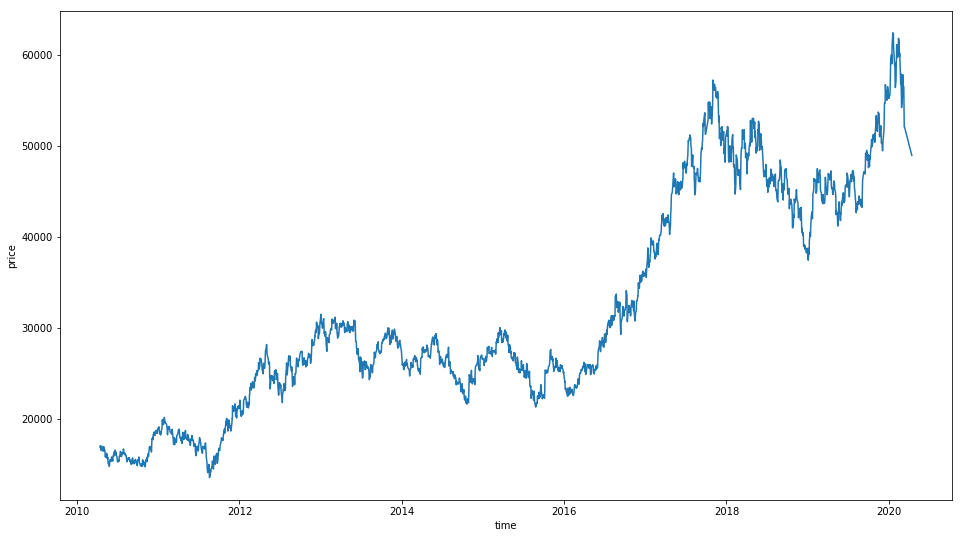

In [3]:
df = df_price.loc[df_price['Year']>=1990]

plt.figure(figsize=(16, 9))
sns.lineplot(y=df['Close'], x=df['Date'])
plt.xlabel('time')
plt.ylabel('price')

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols
df_scaled.dropna(inplace=True)
print(df_scaled)

          Open      High       Low     Close    Volume
0     0.062500  0.061400  0.066722  0.067623  0.237617
1     0.073675  0.067540  0.071281  0.071721  0.282128
2     0.070778  0.065903  0.070037  0.068852  0.170113
3     0.063328  0.058535  0.063821  0.060246  0.191046
4     0.059189  0.055260  0.061749  0.060656  0.209821
5     0.063742  0.063856  0.067551  0.070492  0.204081
6     0.068295  0.062219  0.066722  0.065984  0.265328
7     0.067881  0.061809  0.064650  0.061475  0.238740
8     0.062500  0.059353  0.065479  0.063115  0.201130
9     0.060844  0.057716  0.064235  0.063525  0.201612
10    0.056291  0.052395  0.060506  0.059426  0.247483
11    0.060430  0.054851  0.059677  0.059426  0.175277
12    0.059603  0.063447  0.064235  0.069262  0.351119
13    0.066639  0.060581  0.064235  0.061066  0.225009
14    0.064570  0.059763  0.065479  0.063115  0.141284
15    0.055050  0.049939  0.057190  0.054918  0.348944
16    0.047185  0.041752  0.048073  0.046721  0.585749
17    0.04

In [5]:
TEST_SIZE = 488
train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

def make_dataset(data, label, window_size=15):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [6]:
feature_cols = ['Open', 'High', 'Low', 'Volume']
label_cols = ['Close']

train_feature = train[feature_cols]
train_label = train[label_cols]
test_feature = test[feature_cols]
test_label = test[label_cols]

# train dataset
train_feature, train_label = make_dataset(train_feature, train_label, 20)

# train, validation set 생성
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

x_train.shape, x_valid.shape
# ((6086, 20, 4), (1522, 20, 4))

# test dataset (실제 예측 해볼 데이터)
test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape
# ((180, 20, 4), (180, 1))

((468, 20, 4), (468, 1))

In [7]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM
from decimal import Decimal 
from time import time
from tensorflow.python.keras.callbacks import TensorBoard

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(1))

Using TensorFlow backend.


In [8]:
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model_path = '/home/inlabws/SY_TEST/keras_lstm/model'
filename = os.path.join(model_path, '10_tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                    epochs=200, 
                    batch_size=16,
                    validation_data=(x_valid,y_valid), 
                    callbacks=[early_stop, checkpoint])


Train on 1545 samples, validate on 387 samples
Epoch 1/200
1545/1545 [==============================] - 3s 2ms/step - loss: 0.0137 - val_loss: 4.4392e-04

Epoch 00001: val_loss improved from inf to 0.00044, saving model to /home/inlabws/SY_TEST/keras_lstm/model/10_tmp_checkpoint.h5
Epoch 2/200
1545/1545 [==============================] - 3s 2ms/step - loss: 4.3218e-04 - val_loss: 4.0056e-04

Epoch 00002: val_loss improved from 0.00044 to 0.00040, saving model to /home/inlabws/SY_TEST/keras_lstm/model/10_tmp_checkpoint.h5
Epoch 3/200
1545/1545 [==============================] - 3s 2ms/step - loss: 3.9813e-04 - val_loss: 3.7948e-04

Epoch 00003: val_loss improved from 0.00040 to 0.00038, saving model to /home/inlabws/SY_TEST/keras_lstm/model/10_tmp_checkpoint.h5
Epoch 4/200
1545/1545 [==============================] - 3s 2ms/step - loss: 3.6109e-04 - val_loss: 3.5138e-04

Epoch 00004: val_loss improved from 0.00038 to 0.00035, saving model to /home/inlabws/SY_TEST/keras_lstm/model/10_tm

In [9]:
# weight 로딩
model.load_weights(filename)

# 예측
pred = model.predict(test_feature)

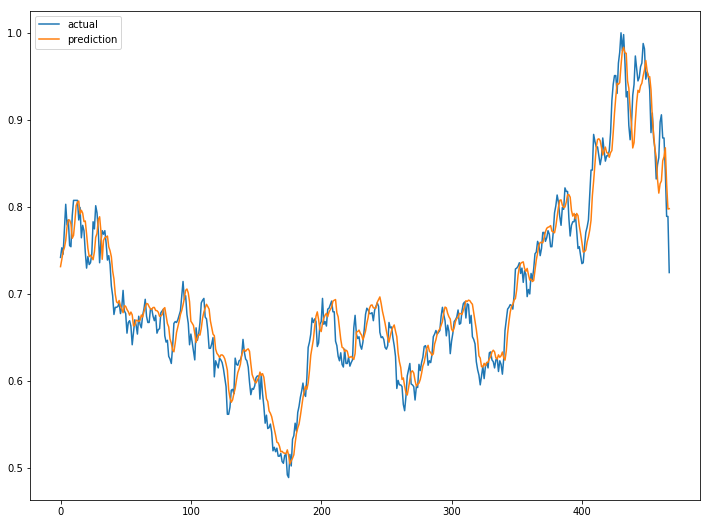

In [10]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()